In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:


class Point:
    def __init__(self, x=0, y=0):    
        x = x
        y = x


num_lines = 768
line_length = 0.12
angle = 0.04
tan_angle = np.tan(angle)


vertical_lines = np.zeros(num_lines)
for i in range(num_lines):
    vertical_lines[i] = i * line_length / (num_lines - 1)

# Define the rotated lines (assuming y-intercepts evenly spaced)
rotated_lines = np.zeros(num_lines)
for j in range(num_lines):
    rotated_lines[j] = j * line_length / (num_lines - 1) # Evenly spaced between 0 and 12 cm

# Calculate the intersection points
intersection_points = []
for c_i in vertical_lines:
    for b_j in rotated_lines:
        intersection = Point()
        intersection.x = c_i
        intersection.y = tan_angle * c_i + b_j
        intersection_points.append(intersection)

# Print the intersection points
for point in intersection_points:
    print("Intersection at (", point.x, ", ", point.y, ")")



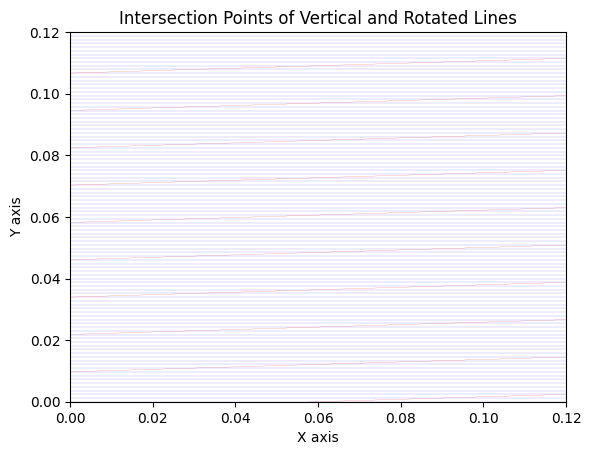

In [29]:


# Define parameters
num_lines = 100
line_length = 0.12  # 12 cm
angle = 0.04  # 40 mrad in radians
tan_angle = np.tan(angle)

# Define the vertical lines
x_vertical = np.linspace(0, line_length, num_lines)

# Define the rotated lines
y_intercepts = np.linspace(0, line_length, num_lines)

# Create figure and axis
fig, ax = plt.subplots()

# Plot vertical lines
for x in x_vertical:
    ax.plot([0, line_length], [x, x], 'b', linewidth=0.1)  # 'b' for blue

# Plot rotated lines (almost vertical)
for i, b in enumerate(y_intercepts):
    x_vals = np.array([0, line_length])
    y_vals = tan_angle * (x_vals - 0.06) + b  # Shift by 0.06 to ensure full overlap
    
    if i % 10 ==0 :
        ax.plot(x_vals, y_vals, 'r', linewidth=0.1)  # 'r' for red
    
    

# Calculate and plot intersection points
intersection_points_x = []
intersection_points_y = []

for x in x_vertical:
    for b in y_intercepts:
        y = tan_angle * (x - 0.06) + b  # Adjust for the shift
        intersection_points_x.append(x)
        intersection_points_y.append(y)

# ax.scatter(intersection_points_x, intersection_points_y, color='green')

# Set plot limits
ax.set_xlim(0, line_length)
ax.set_ylim(0, line_length)

# Labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Intersection Points of Vertical and Rotated Lines')

# Show plot
plt.show()


In [2]:
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

In [143]:
def get_line_params(xvals, yvals):
    dx = xvals[-1] - xvals[0]
    dy = yvals[-1] - yvals[0]
    
    if dx != 0 and dy != 0: # Regular line
        a = - dy / dx
        b = 1
        c = (yvals[0] + a * xvals[0])
        return a, b, c
    
    elif dx == 0:  # Vertical line x = c
        a = 1
        b = 0
        c = -xvals[0]
        return a, b, c
        
    elif dy == 0:   # Horizontal line y = c
        a = 0
        b = 1
        c = -yvals[0]
        return a, b, c


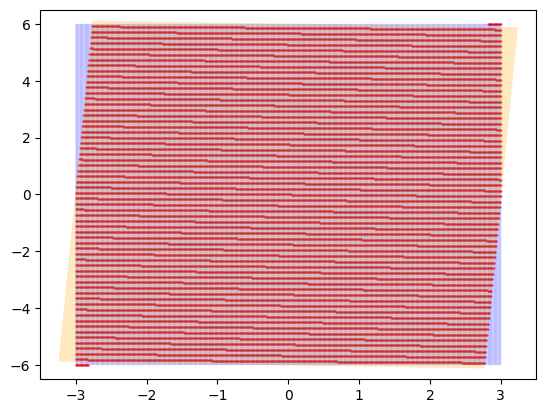

In [185]:
x = np.linspace(-3, 3, 769)
y = np.linspace(-6, 6, 769)

# coords_top = np.meshgrid(x, y)
coords_top = DoRotation(x, y, 0)
coords_bottom = DoRotation(x, y, 0.04)

top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

x_intersection_points = []
y_intersection_points = []

for line1 in top_line_params:
    a1, b1, c1 = line1
    for line2 in bottom_line_params:
        a2, b2, c2 = line2
        
        x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
        y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
        
        if abs(x_intercept) <= 3 and abs(y_intercept) <= 6:
            x_intersection_points.append(x_intercept)
            y_intersection_points.append(y_intercept)
        
            # print(x_intercept, y_intercept)
        
plt.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
plt.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
plt.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
plt.xlim(-3.5, 3.5)
plt.ylim(-6.5, 6.5)

plt.savefig("test-vert.pdf")

In [258]:
def rotate_point(px, py, cx, cy, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    px -= cx
    py -= cy
    xnew = px * c - py * s
    ynew = px * s + py * c
    px = xnew + cx
    py = ynew + cy
    return px, py

def point_in_rectangle(px, py, rect):
    rx_min, rx_max = min(rect[:, 0]), max(rect[:, 0])
    ry_min, ry_max = min(rect[:, 1]), max(rect[:, 1])
    return rx_min < px < rx_max and ry_min < py < ry_max


def check_overlap(length, width, angle1, angle2, point):
    # Define the vertices of the base rectangle (centered at origin, for example)
    rect1 = np.array([[-length, -width], [length, -width], [length, width], [-length, width]])

    # Define the center
    center = (0, 0)
    
    # Apply rotation to the vertices of the second rectangle
    rect2 = np.array([rotate_point(x, y, *center, angle2) for x, y in rect1])
    rect3 = np.array([rotate_point(x, y, *center, angle1) for x, y in rect1])

    rot_point = rotate_point(point[0], point[1], *center, angle2)
    
    # Check if the point is within both rectangles
    inside_rect2 = point_in_rectangle(point[0], point[1], rect3)
    inside_rect3 = point_in_rectangle(rot_point[0], rot_point[1], rect1)

    # Determine if the point is in the overlapping area
    in_overlap = inside_rect2 and inside_rect3
    
    return in_overlap


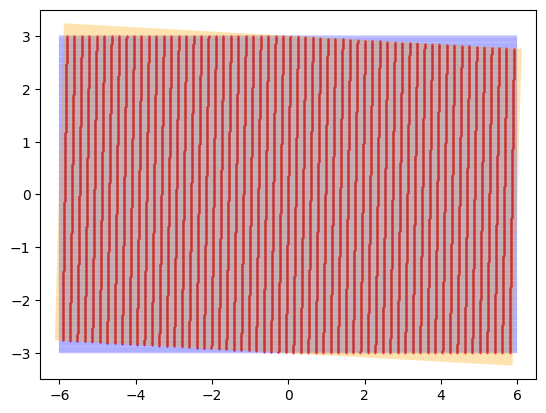

In [259]:
x = np.linspace(-3, 3, 769)
y = np.linspace(-6, 6, 769)

# coords_top = np.meshgrid(x, y)
coords_top = DoRotation(x, y, np.pi/2)
coords_bottom = DoRotation(x, y, np.pi/2+0.04)

top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

x_intersection_points = []
y_intersection_points = []

for line1 in top_line_params:
    a1, b1, c1 = line1
    for line2 in bottom_line_params:
        a2, b2, c2 = line2
        
        x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
        y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
       
        if check_overlap(3, 6, np.pi/2, np.pi/2+0.04, (x_intercept, y_intercept)):
            x_intersection_points.append(x_intercept)
            y_intersection_points.append(y_intercept)
 
                
plt.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
plt.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
plt.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
plt.ylim(-3.5, 3.5)
plt.xlim(-6.5, 6.5)

plt.savefig("test-horiz.pdf")


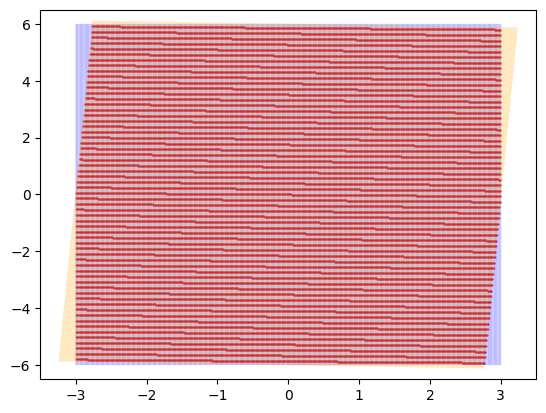

In [261]:
x = np.linspace(-3, 3, 769)
y = np.linspace(-6, 6, 769)

# coords_top = np.meshgrid(x, y)
coords_top = DoRotation(x, y, 0)
coords_bottom = DoRotation(x, y, 0.04)

top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

x_intersection_points = []
y_intersection_points = []

for line1 in top_line_params:
    a1, b1, c1 = line1
    for line2 in bottom_line_params:
        a2, b2, c2 = line2
        
        x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
        y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
        
        if check_overlap(3, 6, 0, 0.04, (x_intercept, y_intercept)):
            x_intersection_points.append(x_intercept)
            y_intersection_points.append(y_intercept)
        
            # print(x_intercept, y_intercept)
        
plt.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
plt.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
plt.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
plt.xlim(-3.5, 3.5)
plt.ylim(-6.5, 6.5)

plt.savefig("test-vert.pdf")